In [7]:
#________ this program get our data MB and makes featurs like 
#         site or organization, market place, holidays and covid as preprocess 

import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.algorithms import unique
import numpy as np 
from matplotlib import pyplot as plt
from persiantools.jdatetime import JalaliDate
from pandas import ExcelWriter

#_____ find N most sold Articles_____
def Nmaxpro (N):
    sum_ordr_pro = []
    for i in unique_Article_list :
        data_every_pro = data[data['Article'] == i ]
        sum1 = sum(list(data_every_pro['Qty in unit of entry']))
        sum_ordr_pro.append(sum1)
    list_of_tuples1 = list(zip(unique_Article_list,sum_ordr_pro))
    df_pro = pd.DataFrame(list_of_tuples1 , columns=['Article','Total_order_pro'])
    sort_df_pro = df_pro.sort_values(by ='Total_order_pro', ascending= False )
    return(sort_df_pro.iloc[:N])



#________ write preprocess data to different sheets of an excel file _______
def save_xls(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for  n,df in list_dfs:
            df.to_excel(writer,sheet_name = str(n))
        writer.save()

#__________ taking data from excel files        
data = pd.read_excel("C:/Users/sony/Desktop/data/MB506.xlsx")        
data1 = pd.read_excel("C:/Users/sony/Desktop/data/covid-data.xlsx")
df_calender1399 = pd.read_excel("C:/Users/sony/Desktop/data/Calendar 1399.xlsx")
df_calender1400 = pd.read_excel("C:/Users/sony/Desktop/data/Calendar 1400.xlsx")


#______________________________________________________
#      site sales or organization sales 
#______________________________________________________

# for organization sales insert 'B000'
#for site sales insert 'D000'

data = data[data['Site']=='D000']

data = data.sort_values(by = 'Posting Date', ascending = True)
data = data.reset_index(drop=True)

data['Qty in unit of entry'] = data['Qty in unit of entry'].abs()

date = list(data['Posting Date'])
Article_list = list(data['Article'])

unique_Article_list = []
for i in Article_list :
    if i not in unique_Article_list:
            unique_Article_list.append(i)


unique_date_list = []
for i in date :
    if i not in unique_date_list:
            unique_date_list.append(i)
            
most_sold= Nmaxpro(3)
most_sold_list = list(most_sold['Article'])


all_datas_list = []

#______acording to each article in most sold list it gathers data and preprocess it ______-
for i in most_sold_list:
    article_df = data[data['Article'] == i]
    #print('________article df_________', article_df )
    #print('article_df',article_df.columns)
    date = list(article_df['Posting Date'])
   
    unique_date_list = []
    for d in date :
        if d not in unique_date_list:
                unique_date_list.append(d)
    
    sum_entry_list = []
    for j in  unique_date_list:
        every_date =  article_df[ article_df['Posting Date'] == j ]
        sum_entry = sum(list(every_date['Qty in unit of entry']))   
        sum_entry_list.append(sum_entry)
    list_of_tuples = list(zip(unique_date_list,sum_entry_list))
    
    #____ summation quantity sales in every day_____
    df_sales = pd.DataFrame(list_of_tuples, columns=['Posting Date','quantity sales'])
  #  print(df_sales)
    
    l1 = []
    for i in  range(len( df_sales)):
        if   article_df.iloc[i,2] == "D000":
            l1.append(1)
        elif article_df.iloc[i,2] == "B000" :
            l1.append(0)
    a1 = {'New Site' : l1}
    site_df = pd.DataFrame(a1)
 
 #______ whether this article belongs to site or organization
    df2 = pd.concat([df_sales,site_df],axis=1 )
    #print(df2)
    
    l2 = []
    for i in  range(len(df2)):
        if  article_df.iloc[i,5] == "E":
            l2.append(1)
        else:
            l2.append(0)
    a2 = {'New Special Stock' : l2}
    sstock_df = pd.DataFrame(a2)
    
#____________whether this article belongs to market place 
    df3 = pd.concat([df2,sstock_df],axis=1 )

   # print('__________df3_________-',df3)

    o1 = df3['Posting Date'].values
    order_date = pd.to_datetime(o1)

    persian_date = []

    for i in range(0,len(order_date)):
        per_date = JalaliDate(order_date[i]) 
        pdate = per_date.strftime("%c")
        persian_date.append(pdate.split())

    persian_date= np.array(persian_date)
    df4 = pd.DataFrame(persian_date, columns = ['week day','day','month','year'])
    df_jalali= pd.concat([df3, df4], axis=1) 
    
    df1399 =  df_jalali[ df_jalali['year']=='1399']
    df1399['day'] = df1399['day'].astype(str).astype(float)

    df_calender1399 = pd.read_excel("C:/Users/sony/Desktop/data/Calendar 1399.xlsx")

    df_calender1399 = df_calender1399[['month','day','holiday']]

    final_df1399 = pd.merge(df1399,df_calender1399,on = ['day','month'], how = "left")


    df1400 =  df_jalali[ df_jalali['year']=='1400']
    df1400['day'] = df1400['day'].astype(str).astype(float)

    df_calender1400 = pd.read_excel("C:/Users/sony/Desktop/data/Calendar 1400.xlsx")

    df_calender1400 = df_calender1400[['month','day','holiday']]
    final_df1400 = pd.merge(df1400,df_calender1400,on = ['day','month'], how = "left")

#____________ adding holiday featur__________________
    all_data_ho = pd.DataFrame()
    all_data_ho = all_data_ho.append(final_df1399)
    all_data_ho = all_data_ho.append(final_df1400)
    #print(all_data_ho)
    
#____________adding covid featur___________________
    data1 = pd.read_excel("C:/Users/sony/Desktop/data/covid-data.xlsx")
    data1 = data1 [data1 ['location']=='Iran']
    data1  = data1.reset_index(drop=True)
    data1 = data1[['date','new_cases_smoothed', 'new_deaths_smoothed',
    'new_tests_smoothed','new_vaccinations_smoothed',
                 'total_deaths','total_cases' ]]
    
    data1['new_cases_smoothed'] = 0.33 *  data1['new_cases_smoothed']
    data1['new_deaths_smoothed'] = 0.33 *  data1['new_deaths_smoothed']
    data1['new_tests_smoothed'] = 0.33 *  data1['new_tests_smoothed']
    data1['new_vaccinations_smoothed'] = 0.33 *  data1['new_vaccinations_smoothed']
    data1['total_deaths'] = 0.33 *  data1['total_deaths']
    data1['total_cases'] = 0.33 *  data1['total_cases']
    
    
    
    date_covid = list(data1['date'])
   
    date_list = list(all_data_ho['Posting Date'])
    unique_date_list = []
    for i in date_list :
        if i not in unique_date_list:
                unique_date_list.append(i)
                
    new_list=[]

    for date in unique_date_list:
        x = date.strftime('%Y-%m-%d')
        new_list.append(x)
  
    
    all_data_covid = pd.DataFrame()
    for j in new_list:
        data_date = data1[data1['date']==j]
        all_data_covid = all_data_covid.append(data_date)
    all_data_covid  =  all_data_covid.reset_index(drop=True)
    all_data_ho  =   all_data_ho.reset_index(drop=True)
    all_datas = pd.concat([  all_data_ho, all_data_covid], axis=1)    
    all_datas_list.append( all_datas)

tuples1 = list(zip(most_sold_list,all_datas_list))

#____________add all featurs of articles in different sheets of an excel file______________

save_xls(tuples1, 'C:/Users/sony/Desktop/data/preprocess Articles.xlsx')



C:\Users\sony\AppData\Local\Temp/ipykernel_9200/469026124.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1399['day'] = df1399['day'].astype(str).astype(float)
C:\Users\sony\AppData\Local\Temp/ipykernel_9200/469026124.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1400['day'] = df1400['day'].astype(str).astype(float)
C:\Users\sony\AppData\Local\Temp/ipykernel_9200/469026124.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

['10001768', '10000705', '10000620']
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 125 samples in 0.001s...
[t-SNE] Computed neighbors for 125 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 125 / 125
[t-SNE] Mean sigma: 51648.965764


C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.197670
[t-SNE] KL divergence after 750 iterations: 0.079407

_________ 2 components TSNE for  Article___________ 10001768


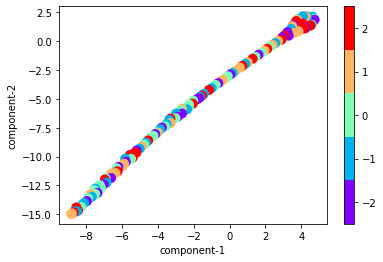

C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 45 nearest neighbors...
[t-SNE] Indexed 46 samples in 0.001s...
[t-SNE] Computed neighbors for 46 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 46 / 46
[t-SNE] Mean sigma: 150005.060650
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.720284
[t-SNE] KL divergence after 1000 iterations: 0.252739

_________ 2 components TSNE for  Article___________ 10000705


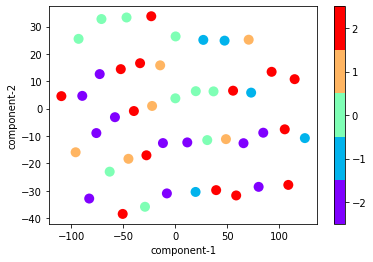

C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 118 samples in 0.001s...
[t-SNE] Computed neighbors for 118 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 118 / 118
[t-SNE] Mean sigma: 55696.308973
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.304298
[t-SNE] KL divergence after 750 iterations: 0.076163

_________ 2 components TSNE for  Article___________ 10000620


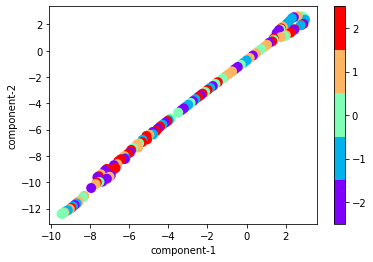



 @@@@ Article  10001768 @@@@@@ 
 

_________peaks new cases in covid cases in time range article :____________ 
 10001768


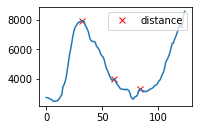

C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 125 samples in 0.000s...
[t-SNE] Computed neighbors for 125 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 125 / 125
[t-SNE] Mean sigma: 374.772512
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.300453
[t-SNE] KL divergence after 1000 iterations: 0.531706
_________ find peaks of our data with reduction one dimention on Article_________ 10001768


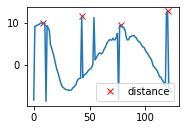



 @@@@ Article  10000705 @@@@@@ 
 

_________peaks new cases in covid cases in time range article :____________ 
 10000705


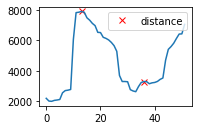

C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 51 nearest neighbors...
[t-SNE] Indexed 52 samples in 0.000s...
[t-SNE] Computed neighbors for 52 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 52 / 52
[t-SNE] Mean sigma: 1815.960904
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.228783
[t-SNE] KL divergence after 1000 iterations: 2.924681
_________ find peaks of our data with reduction one dimention on Article_________ 10000705


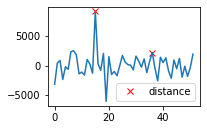



 @@@@ Article  10000620 @@@@@@ 
 

_________peaks new cases in covid cases in time range article :____________ 
 10000620


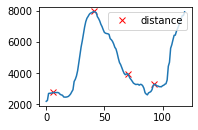

C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sony\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.005s...
[t-SNE] Computed neighbors for 120 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 359.180035
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.761566
[t-SNE] KL divergence after 1000 iterations: 0.434453
_________ find peaks of our data with reduction one dimention on Article_________ 10000620


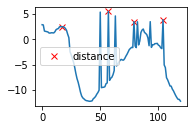

In [6]:
#_________ in this cell the components of TSNE will be made and plot
#          the peaks of new cases in covid will be found and peaks of our reduction data also are found

from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks


#_________ read the data from different sheets of excel file which every sheet belongs to one of most sold articles_______

f = pd.ExcelFile('C:/Users/sony/Desktop/data/preprocess Articles.xlsx')
sheet_name = f.sheet_names
print(sheet_name)

for i in sheet_name:
   
    df_article= f.parse(sheet_name = str(i))
    df_article =  df_article[['quantity sales', 'New Site', 'New Special Stock','holiday',
        'new_cases_smoothed', 'new_deaths_smoothed', 'new_tests_smoothed',
      'new_vaccinations_smoothed', 'total_deaths', 'total_cases']]



    features = ['quantity sales', 'New Site', 'New Special Stock','holiday',
        'new_cases_smoothed', 'new_deaths_smoothed', 'new_tests_smoothed',
      'new_vaccinations_smoothed', 'total_deaths', 'total_cases']
    df_article = df_article.dropna()
    a = len(df_article)
    
    x =  df_article.loc[:, features].values
  
     
        
    y = list(  df_article['New Special Stock'])


    #____________plot tsne 2 dimention_______________

    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    tsne_comp = tsne.fit_transform(x) 

    component_df = pd.DataFrame(data = tsne_comp
                 , columns = ['component-1','component-2'])

    x1 = component_df[['component-1']].to_numpy()
 
    y1 = component_df[['component-2']].to_numpy()
 
    z = np.random.randint(-2, 3, a)
    print()
    print('_________ 2 components TSNE for  Article___________',i)
    plt.xlabel('component-1')
    plt.ylabel('component-2')
   


    cmap = plt.cm.rainbow
    norm = colors.BoundaryNorm(np.arange(-2.5, 3, 1), cmap.N)

    plt.scatter(x1, y1, c=z, cmap=cmap, norm=norm, s=100, edgecolor='none')
    plt.colorbar(ticks=np.linspace(-2, 2, 5))

    plt.show()
    
for i in sheet_name:
   
    df_article= f.parse(sheet_name = str(i))
    df_article =  df_article[['quantity sales', 'New Site', 'New Special Stock','holiday',
        'new_cases_smoothed', 'new_deaths_smoothed', 'new_tests_smoothed',
      'new_vaccinations_smoothed', 'total_deaths', 'total_cases']]
    list_cases = list(df_article['new_cases_smoothed'])
    new_cases = np.array(list_cases)
#___________ find the covid peaks according to our data______
    x = new_cases
    print()
    print("\n @@@@ Article ",i,"@@@@@@ \n ")
    print("\n_________peaks new cases in covid cases in time range article :____________ \n",i)
    peaks, _ = find_peaks(x, distance=20)
    peaks2, _ = find_peaks(x, prominence=1)      # BEST!
    peaks3, _ = find_peaks(x, width=20)
    peaks4, _ = find_peaks(x, threshold=0.4)     # Required vertical distance to its direct neighbouring samples, pretty useless
    plt.subplot(2, 2, 1)
    plt.plot(peaks, x[peaks], "xr"); plt.plot(x); plt.legend(['distance'])
    plt.show()
    
 #____________ find the peaks our reduction data in 1 componenet_________
    
    features = ['quantity sales', 'New Site', 'New Special Stock','holiday',
        'new_cases_smoothed', 'new_deaths_smoothed', 'new_tests_smoothed',
      'new_vaccinations_smoothed', 'total_deaths', 'total_cases']
    df_article = df_article.dropna()
    a = len(df_article)
    
    y =  df_article.loc[:, features].values
    tsne = TSNE(n_components=1, verbose=1, random_state=123)
    tsne_comp = tsne.fit_transform(x.reshape(-1,1)).ravel() 

    component_df = pd.DataFrame(data = tsne_comp
                 , columns = ['component-1'])
 
    print('_________ find peaks of our data with reduction one dimention on Article_________', i)
    
    list_co = list(component_df['component-1'])
    y1 = np.array(list_co)
    peaks1, _ = find_peaks(y1, distance=20)
    plt.subplot(2, 2, 1)
    plt.plot(peaks1, y1[peaks1], "xr"); plt.plot(y1); plt.legend(['distance'])
    plt.show()





